## KennGlacHobosCorrection.ipynb, Kennicott Glacier hobo corrections

This code imports data from four hobo loggers that were left out on Kennicott Glacier in 2021 ("KennGlacHobosData.xlsx").

It first plots then data, then slices off the section at end of season when the four sensors experienced identical temperatures (10/1-10/4/2021). It compares these records and corrects three of the sensors very slightly so that they are all essentially identical. It then applies that correction to the rest of the data from the summer to produce a good quality record of temps at all stations. 

Then it compares the Gates AWS hobo to the Gates AWS NPS (long-term record), finds them close but not identical, so does a regression to predict Gates AWS (hobo)
from the NPS station. I apply that regression to ALL hobos since they presumably all have that same offset.

Finally it saves the corrected values, for only the period of good data on the glacier (6/11/2021 17:00 to 9/8/2021 12:00), as a pickle file (homogenized_hobos.pickle) which contains a pandas table, homogenized, with fields Gates3600_degC (corrected), Kenn6100_degC (corrected), GatesAWS_degC (uncorrected), and ChineseAWS_degC (corrected). It also has GatesNPS_degC, which is the raw data from the NPS weather station.


In [1]:
## IMPORT PACKAGES

# standard
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import datetime
import os, csv

# specialized
from scipy import stats
from scipy.optimize import curve_fit
# statsmodels is a nice tool for regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
from numpy.polynomial import Chebyshev
from numpy.polynomial.chebyshev import chebfit
from mpl_toolkits.mplot3d import Axes3D
import pickle
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# set default figure size
figsize=(10,6)

In [2]:
## LOAD DATA

# set working directory
data_dir = r'~/MLo/KennGlac/data'
# Load an excel workbook that is in the local directory
xlsx=pd.ExcelFile(os.path.join(data_dir,'KennGlacHobosData.xlsx'))
# Load the first worksheet as 'wb', treat -9999 as nan|, make first column (dates) the index
wb=pd.read_excel(xlsx,sheet_name='Sheet1',na_values=[-9999],index_col=0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
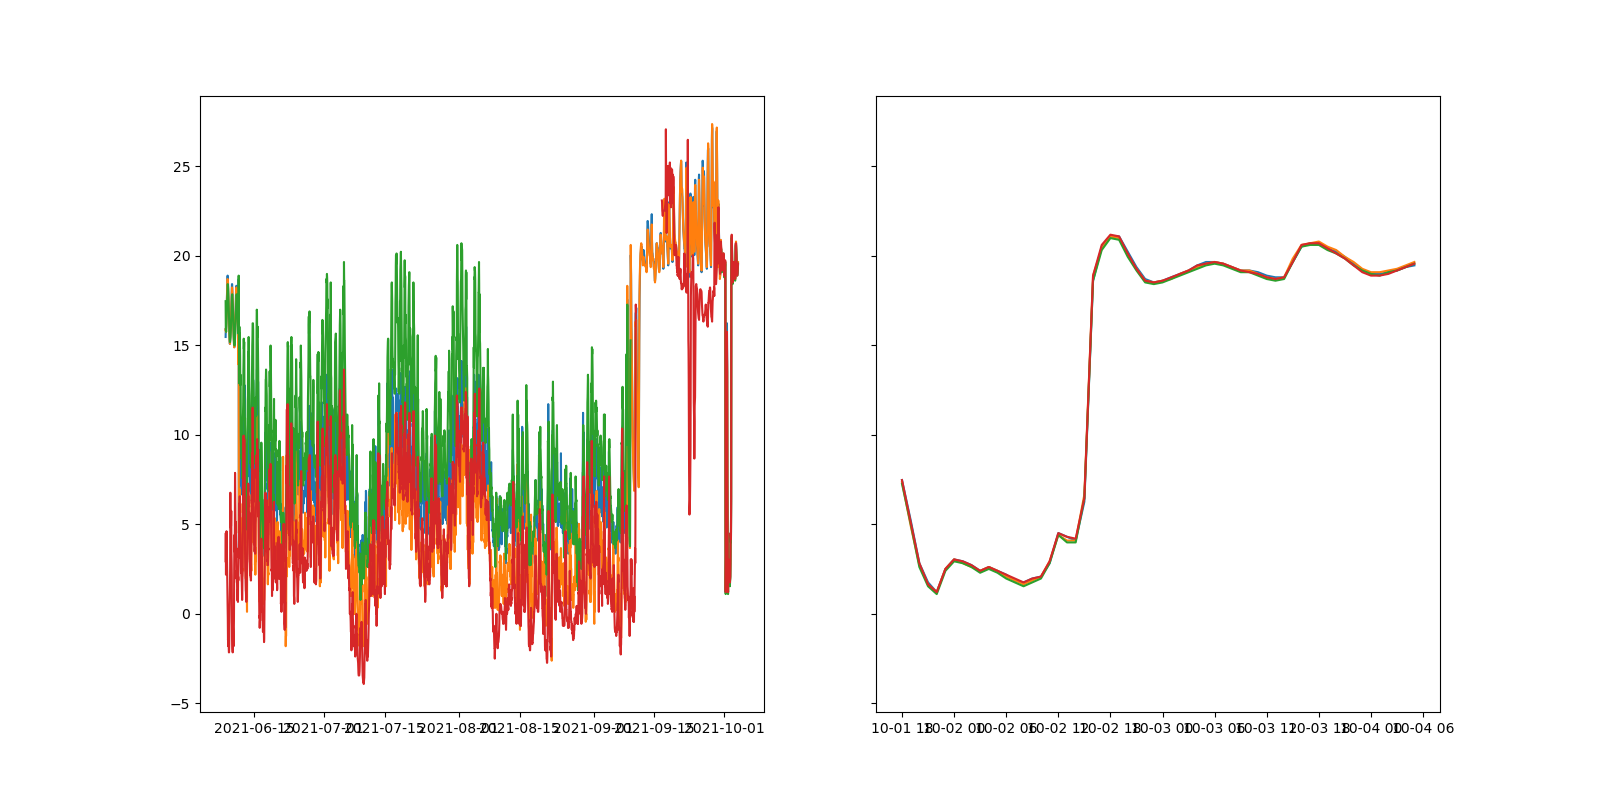

In [3]:
## VIEW DATA

# # Print summary of worksheet (2 first 2 last rows)
# print(wb.head(2))

# # Print datatypes (dtypes) of DataFrame (wb)
# print(wb.dtypes)

## PLOT
# set up for subplots
fig,axs = plt.subplots(1,2,sharey=True,figsize=(16,8))

# Plot all data in left panel
plt.subplot(1,2,1)
plt.plot(wb)

# Select data from specific range
## INPUT: Choose start and end times ## This is the time of overlap for the hobos at end of season
startoverlap = pd.to_datetime('10/1/2021 18:00')
endoverlap = pd.to_datetime('10/4/2021 05:00')

# create 'overlap', a table of just the time when all the sensors were in the same place
overlap=wb[(startoverlap) : (endoverlap)]
    
# Plot data from that range in right panel
plt.subplot(1,2,2)
plt.plot(overlap)

plt.show()

Coefficients: [[1.00207753]]
Mean squared error: 0.01
Coefficient of determination: 1.00
Coefficients: [[0.99843999]]
Mean squared error: 0.00
Coefficient of determination: 1.00
Coefficients: [[1.00387343]]
Mean squared error: 0.01
Coefficient of determination: 1.00


(-1.0498055555555559,
 22.04591666666667,
 -1.0593611111111112,
 22.246583333333334)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
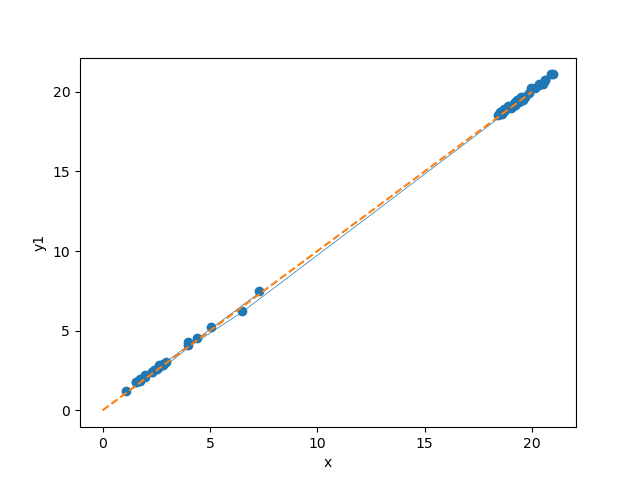

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
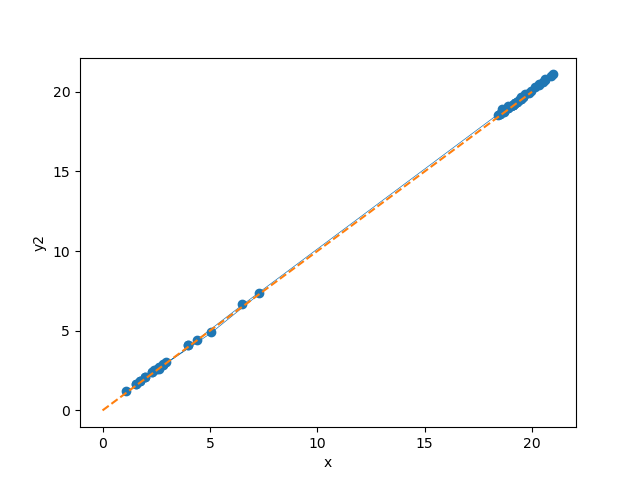

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
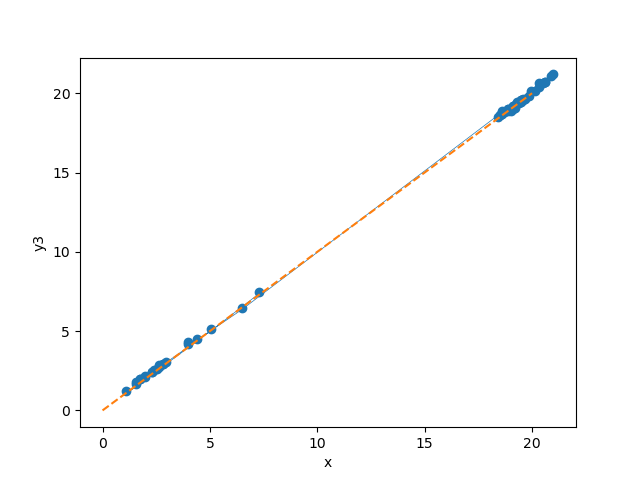

In [4]:
## PERFORM REGRESSION AND VIEW RESULTS 

# This is a cumbersome way to do it, but it worked. So leaving it. 

# call Gates AWS the "right" value since it is our most stable and consistent measurement
# start with Gates3600 eg. x=rng['Gates AWS degC']. Make it into an array and reshape it as column
# probably a better way to do this
x=np.asarray(overlap['Gates AWS degC'])
x=x.reshape(-1,1)
y1=np.asarray(overlap['Gates 3600 degC'])
y1=y1.reshape(-1,1)
y2=np.asarray(overlap['Kenn 6100 degC'])
y2=y2.reshape(-1,1)
y3=np.asarray(overlap['Chinese AWS degC'])
y3=y3.reshape(-1,1)


# define a 1:1 line for plotting
xline=[0,20]
yline=[0,20]


# FIT AND PLOT MODELS

# Gates 3600 (how do we change y1 to get x)
regr1=linear_model.LinearRegression()
regr1.fit(y1,x)
y1_pred=regr1.predict(y1)
# save stats
print('Coefficients:', regr1.coef_)
# save coefficients
intercepts=(regr1.intercept_)
coefs=(regr1.coef_)
print('Mean squared error: %.2f'
         % mean_squared_error(x,y1_pred))
print('Coefficient of determination: %.2f'
         % r2_score(y1,y1_pred))
# plot it
fig,ax=plt.subplots()
fig=plt.scatter(x,y1)
fig=plt.plot(x,y1_pred,linewidth=0.5)
# plot one to one line
plt.plot(xline,yline,linestyle='--')
ax.set_xlabel('x')
ax.set_ylabel('y1')
ax.axis('tight')


# Kenn 6100 (how do we change y2 to get x)
regr2=linear_model.LinearRegression()
regr2.fit(y2,x)
y2_pred=regr2.predict(y2)
# save stats
print('Coefficients:', regr2.coef_)
# save coefficients
intercepts=np.append(intercepts,regr2.intercept_)
coefs=np.append(coefs,regr2.coef_)
print('Mean squared error: %.2f'
         % mean_squared_error(x,y2_pred))
print('Coefficient of determination: %.2f'
         % r2_score(y2,y2_pred))
# plot it
fig,ax=plt.subplots()
fig=plt.scatter(x,y2)
fig=plt.plot(x,y2_pred,linewidth=0.5)
# plot one to one line
plt.plot(xline,yline,linestyle='--')
ax.set_xlabel('x')
ax.set_ylabel('y2')
ax.axis('tight')

# Chinese AWS (how do we change y3 to get x)
regr3=linear_model.LinearRegression()
regr3.fit(y3,x)
y3_pred=regr3.predict(y3)
# save stats
print('Coefficients:', regr3.coef_)
# save coefficients
intercepts=np.append(intercepts,regr3.intercept_)
coefs=np.append(coefs,regr3.coef_) 
print('Mean squared error: %.2f'
         % mean_squared_error(x,y3_pred))
print('Coefficient of determination: %.2f'
         % r2_score(y3,y3_pred))
# plot it
fig,ax=plt.subplots()
fig=plt.scatter(x,y3)
fig=plt.plot(x,y3_pred,linewidth=0.5)
# plot one to one line
plt.plot(xline,yline,linestyle='--')
ax.set_xlabel('x')
ax.set_ylabel('y3')
ax.axis('tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
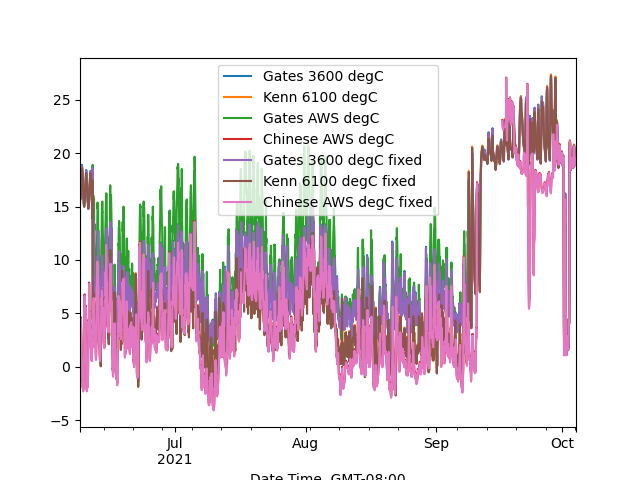

In [5]:
# APPLY REGRESSION COEFFICIENTS TO ORIGINAL DATA AND PLOT
# to do so, convert pandas tables to arrays using *.array


# y1fixed, y2fixed, and y3 fixed are the corrected versions 
# Gates
temp1=np.array(wb['Gates 3600 degC'])
temp1=temp1.reshape(-1,1)
y1fixed=regr1.predict(temp1)
y1fixed=y1fixed.flatten()

# Kenn 6100
temp2=np.array(wb['Kenn 6100 degC'])
temp2=temp2.reshape(-1,1)
y2fixed=regr2.predict(temp2)
y2fixed=y2fixed.flatten()

# Chinese AWS (have to remove NaNs)
temp3=np.array(wb['Chinese AWS degC'])
# Chinese data has some NaNs and "reshape' can't handle that. use this to harvest out just the real numbers
# find nans and change to zeros
nans2=np.argwhere(np.isnan(temp3))
temp3[nans2]=0

# run regression
temp3=temp3.reshape(-1,1)
y3fixed=regr3.predict(temp3)
y3fixed=y3fixed.flatten()

# need to remove 0 values from Chinese AWs
nans2=nans2.flatten()
y3fixed[nans2]=np.nan

wb['Gates 3600 degC fixed']=y1fixed.tolist()
wb['Kenn 6100 degC fixed']=y2fixed.tolist()
wb['Chinese AWS degC fixed']=y3fixed.tolist()

# Plot all data on same axis
wb.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
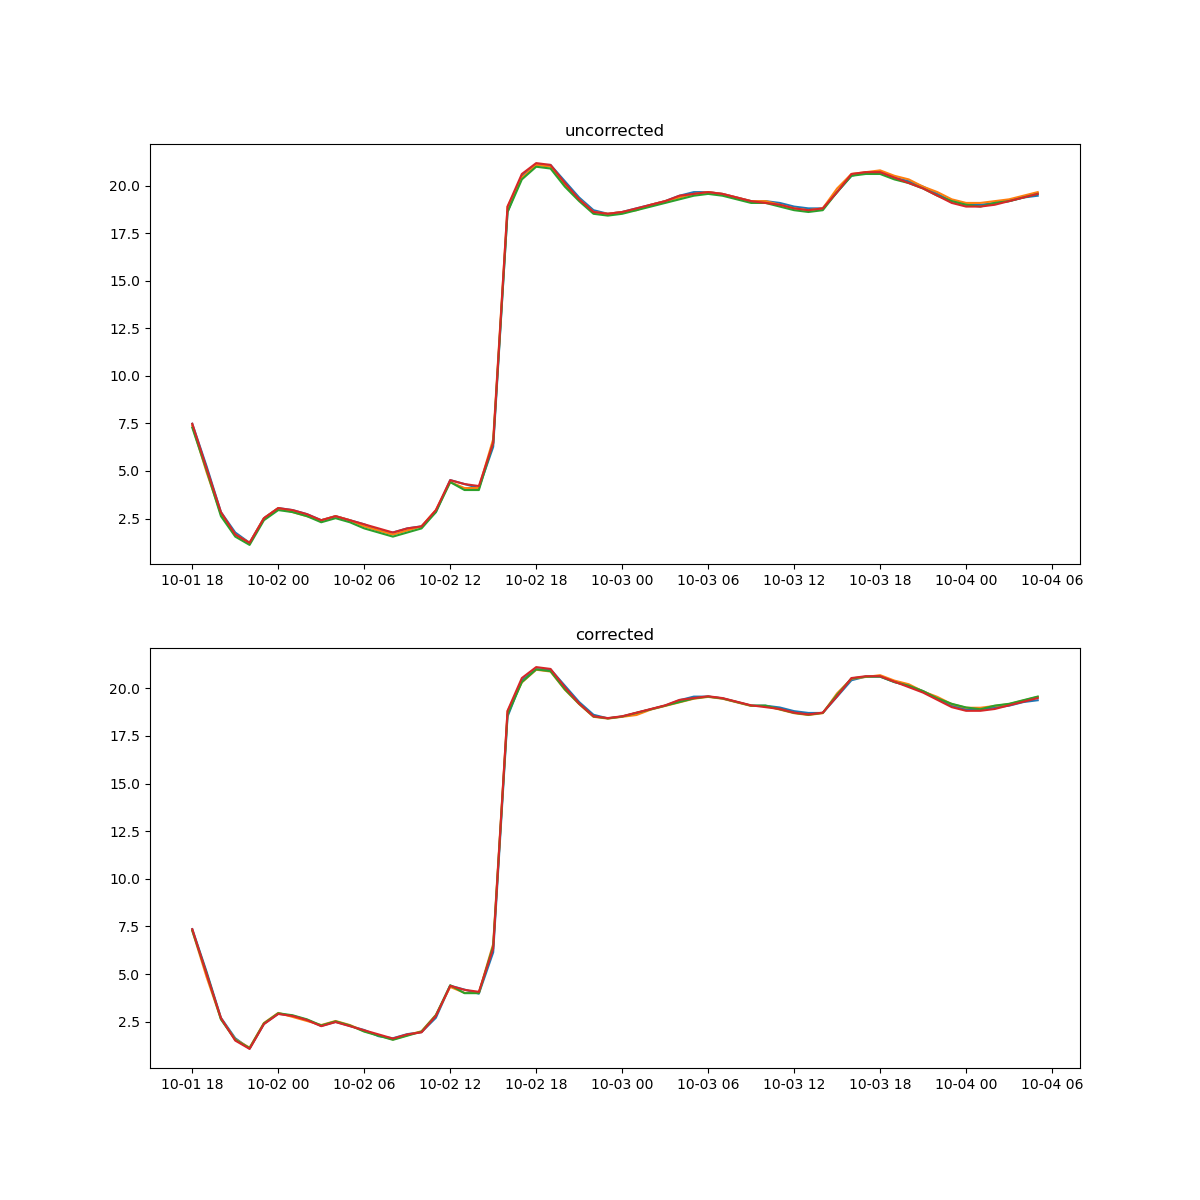

In [6]:
## PLOT CORRECTED VERSIONS WITH ORIGINALS ON SHORT TIME SLICE
fig,ax = plt.subplots(2,1,figsize=(12,12))


OLDlab=wb.loc[datetime.datetime(2021,10,1,18,0,0):datetime.datetime(2021,10,4,5,0,0),['Gates 3600 degC','Kenn 6100 degC','Gates AWS degC','Chinese AWS degC']]
plt.subplot(2,1,1)
fig=plt.plot(OLDlab)
ax[0].set_title('uncorrected')

NEWlab=wb.loc[datetime.datetime(2021,10,1,18,0,0):datetime.datetime(2021,10,4,5,0,0),['Gates 3600 degC fixed','Kenn 6100 degC fixed','Gates AWS degC','Chinese AWS degC fixed']]
plt.subplot(2,1,2)
fig=plt.plot(NEWlab)
ax[1].set_title('corrected')

plt.show()

[]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
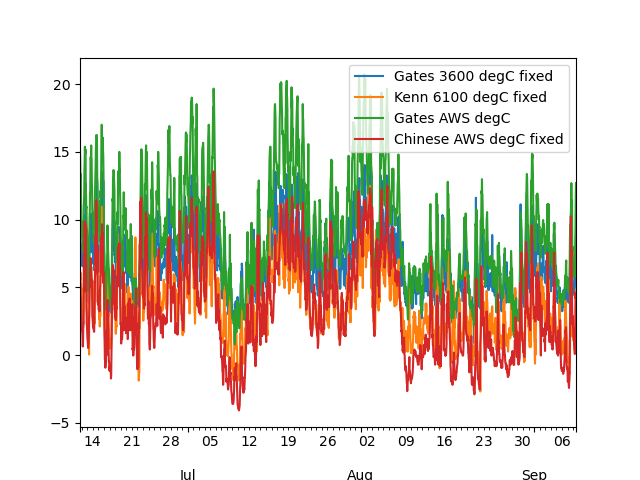

In [7]:
## PLOT CORRECTED VERSIONS (only) ON GOOD COMPARABLE TIME SLICE

# Select data from specific range
NEWfield=wb.loc[datetime.datetime(2021,6,11,17,0,0):datetime.datetime(2021,9,8,12,0,0),['Gates 3600 degC fixed','Kenn 6100 degC fixed','Gates AWS degC','Chinese AWS degC fixed']]
# Plot data from that range
NEWfield.plot();

# Check for isnans (there aren't any)
# find nans and change to zeros
temp=np.array(NEWfield)
nans5=np.argwhere(np.isnan(temp))
print(nans5)

In [8]:
## TURN CORRECTED VERSION ON GOOD TIMESLICE INTO NEW PANDAS TABLE "HOMOGENIZED" 

# NEWfield is the timesliced table. Rename column headers
dict = {'Gates 3600 degC fixed': 'Gates3600_degC', 'Gates AWS degC': 'GatesAWS_degC', 'Kenn 6100 degC fixed': 'Kenn6100_degC', 'Chinese AWS degC fixed': 'ChineseAWS_degC'}
NEWfield.rename(columns=dict,inplace=True)

# Rename table
homogenized=NEWfield


In [9]:
## TAKE ALL THE HOMOGENIZED HOBO RECORDS AND HOMOGENIZE THEM WITH THE GATES AWS RECORD
## DO SO BY FINDING THE RIGHT REGRESSION BETWEEN GATES AWS (HOBO) AND GATES AWS (NPS LONG-TERM)
## THEN APPLY CORRECTION TO ALL THE HOBOS

# First load Gates long-term AWS record
# set working directory
data_dir = r'~/MLo/KennGlac/data/Raw_Climate_Records/current 2021/GATES hrly all vars 2016_01_01 to 2021_11_10/from telemetry'
# Load an excel workbook that is in the local directory
csv=os.path.join(data_dir,'GGLA2.2021-11-10.csv')
# Load the first worksheet as 'wb', treat -9999 as nan|, make first column (dates) the index
nps=pd.read_csv(csv,skiprows=[11],na_values=[-9999],header=10,parse_dates=['Date_Time'])
# convert zulu time to AK Time
nps.loc[:,'AKdate'] = nps['Date_Time'].dt.tz_convert('US/Alaska')
# shift timestamp 33 minutes to read on the hour
nps.AKdate = nps.AKdate - pd.Timedelta(33,'minutes') # on the hour
# keep time as it is but remove time zone info (stays local AK)
nps.loc[:,'AKdate'] = nps.AKdate.dt.tz_localize(tz=None)
nps=nps.set_index(['AKdate'])

# get slice of NPS long-term data that matches hobo data
nps_hobo_overlap=nps.loc[datetime.datetime(2021,6,11,17,0,0):datetime.datetime(2021,9,8,12,0,0),['air_temp_set_1']]
newcol=nps_hobo_overlap['air_temp_set_1']
# add NPS data to homogenized
homogenized = pd.concat([homogenized,newcol],axis = 1)
# rename long-term data as GatesNPS_degC
homogenized.rename(columns = {'air_temp_set_1':'GatesNPS_degC'},inplace=True)

print(homogenized.head(2))

## DO REGRESSION
# Gates 3600 as a function of Gates AWS
regr3=smf.ols(formula='GatesNPS_degC ~ GatesAWS_degC', data=homogenized).fit()

print(regr3.params)
print(regr3.summary())

## PREDICT GATESAWS TEMPS DIRECTLY FROM GATESNPS
homogenized['GatesAWSpredicted']=homogenized.GatesAWS_degC*regr3.params.GatesAWS_degC + regr3.params.Intercept

                     Gates3600_degC  Kenn6100_degC  GatesAWS_degC  \
2021-06-11 17:00:00       10.535463       6.175847      14.996111   
2021-06-11 18:00:00       10.044445       5.564025      14.421111   

                     ChineseAWS_degC  GatesNPS_degC  
2021-06-11 17:00:00         6.240160          13.50  
2021-06-11 18:00:00         5.109799          13.11  
Intercept        0.447021
GatesAWS_degC    0.919891
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          GatesNPS_degC   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 7.144e+04
Date:                Thu, 10 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:57:29   Log-Likelihood:                -2025.2
No. Observations:                2099   AIC:                             4054.
Df Residua

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
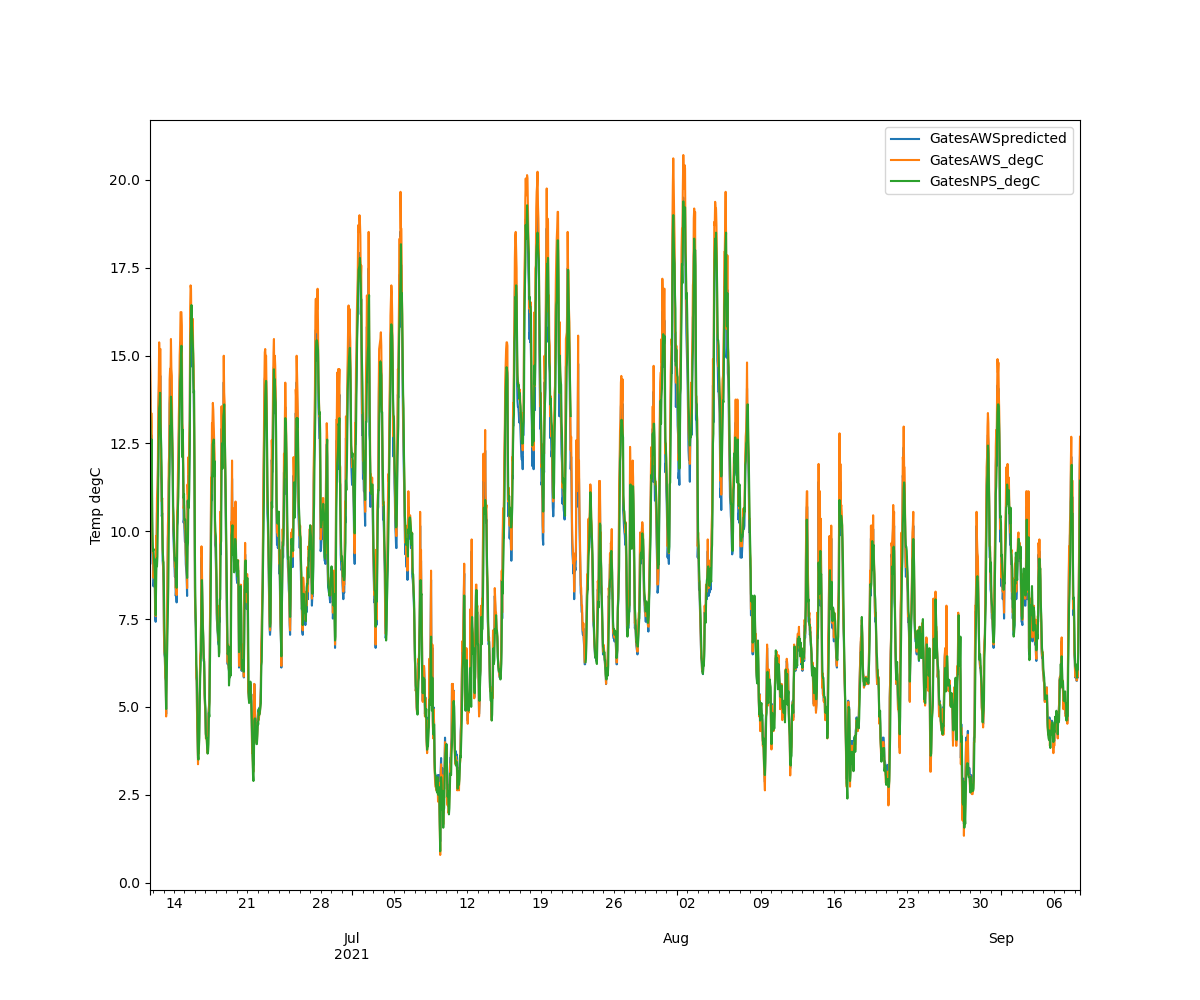

we expect diffraw2 to be smaller if the regression helped
-0.28532343443968045
-3.820563578595727e-15
we expect corr2 to be a better fit if the regression helped
1.00000000
1.00000000


In [10]:
## PLOT NUMBERS FOR VISUAL CONFIRMATION
homogenized.plot(y=['GatesAWSpredicted','GatesAWS_degC','GatesNPS_degC'],ylabel='Temp degC',figsize=(12,10))

plt.show()

## COMPARE TIME SERIES FOR MATHEMATICAL CONFIRMATION
## The tests below just verify that we improved the fit between the hobo and the nps sensor at Gates by doing the regression
print('we expect diffraw2 to be smaller if the regression helped')
diffraw1=homogenized.GatesNPS_degC-homogenized.GatesAWS_degC
print(diffraw1.mean())
diffraw2=homogenized.GatesNPS_degC-homogenized.GatesAWSpredicted
print(diffraw2.mean())
corr1=np.corrcoef(homogenized.GatesNPS_degC,homogenized.GatesAWS_degC)
corr2=np.corrcoef(homogenized.GatesNPS_degC,homogenized.GatesAWSpredicted)
print('we expect corr2 to be a better fit if the regression helped')
print('%.8f' % corr1[1,1])
print('%.8f' % corr2[1,1])

### SUMMARY
We developed a regression that can be used to move all the hobo data into the calibration frame of the Gates AWS station--our primary long-term reference.
We don't want this to change the now-very good match between the sensors on all the hobos, so we will apply the regression to ALL the hobo records.

Then we'll resave the homogenized dataset. 

In [11]:
## PREDICT ALL HOBO VALUES FROM GATES, THEN SAVE

# make the conversions (already converted GatesAWS)
homogenized['Gates3600predicted']=homogenized.Gates3600_degC*regr3.params.GatesAWS_degC + regr3.params.Intercept
homogenized['ChineseAWSpredicted']=homogenized.ChineseAWS_degC*regr3.params.GatesAWS_degC + regr3.params.Intercept
homogenized['Kenn6100predicted']=homogenized.Kenn6100_degC*regr3.params.GatesAWS_degC + regr3.params.Intercept

# clean up homogenized
del homogenized['Gates3600_degC']
del homogenized['GatesAWS_degC']
del homogenized['ChineseAWS_degC']
del homogenized['Kenn6100_degC']

homogenized.rename(columns = {'GatesAWSpredicted':'GatesAWS_degC'},inplace=True)
homogenized.rename(columns = {'Gates3600predicted':'Gates3600_degC'},inplace=True)
homogenized.rename(columns = {'Kenn6100predicted':'Kenn6100_degC'},inplace=True)
homogenized.rename(columns = {'ChineseAWSpredicted':'ChineseAWS_degC'},inplace=True)

# look good?
print(homogenized.head())

## save homogenized data to pickle
# set working directory
data_dir = r'/mnt/c/Users/MGLoso/Documents/software/KennGlac/data'

# set pickle path (data_dir is directory, homogenized_hobos.pickle is dataset)
homogenized_path = os.path.join(data_dir,'homogenized_hobos.pickle')

# save variable dataframes
homogenized.to_pickle(homogenized_path)

# optional: save to csv
# homogenized.to_csv(os.path.join(hobo_data,'homogenized.csv'))

                     GatesNPS_degC  GatesAWS_degC  Gates3600_degC  \
2021-06-11 17:00:00          13.50      14.241805       10.138496   
2021-06-11 18:00:00          13.11      13.712867        9.686813   
2021-06-11 19:00:00          11.83      12.209868        9.051794   
2021-06-11 20:00:00          11.67      12.741361        7.954850   
2021-06-11 21:00:00          12.61      12.387203        7.770489   

                     ChineseAWS_degC  Kenn6100_degC  
2021-06-11 17:00:00         6.187286       6.128125  
2021-06-11 18:00:00         5.147477       5.565316  
2021-06-11 19:00:00         4.574012       6.034749  
2021-06-11 20:00:00         4.381934       4.903007  
2021-06-11 21:00:00         3.705966       5.282636  
